In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Okt

def get_wordCloud(tuples):
    """
    Make WordCloud
    여러개의 문자열로 이루어진 튜플을 인자로 받는다.
    만들어진 img를 리턴한다.
    """
    # 하나의 문자열로 만들어주는 작업 / 튜플안에서 튜플꺼내기
    longStr = ''.join([text for tuple in tuples for text in tuple])

    # 형태소 분석 및 카운터 - 한글만
    okt = Okt()
    nouns = okt.nouns(longStr)
    counter = Counter(nouns)

    wordcloud = WordCloud(
        font_path ="./BMJUA.ttf",
        width=800,
        height=600,
        max_words=80,
        prefer_horizontal=1,
        max_font_size=250,
        background_color='white',
    )

    img = wordcloud.generate_from_frequencies(counter)
    return img

In [5]:
# DB
import pymysql as db
import pprint

local = 'team0402.c43ypw0liaa2.ap-northeast-2.rds.amazonaws.com'  # aws rds 접근
con = db.connect(
    host=local,
    user='team0402',
    db='Team0402_Youtube',
    password='team0402',
    charset='utf8mb4'
)
cur = con.cursor()

def get_result_byQuery(query):
    cur.execute(query)
    return cur.fetchall()

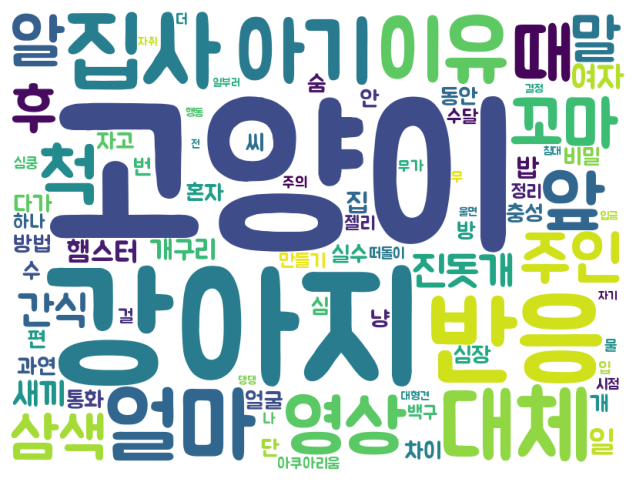

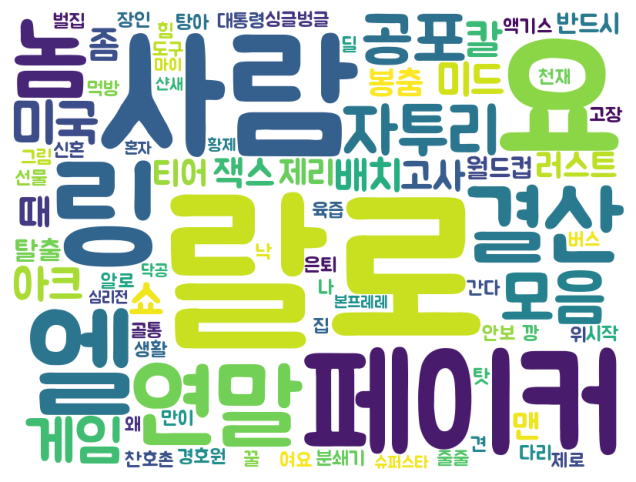

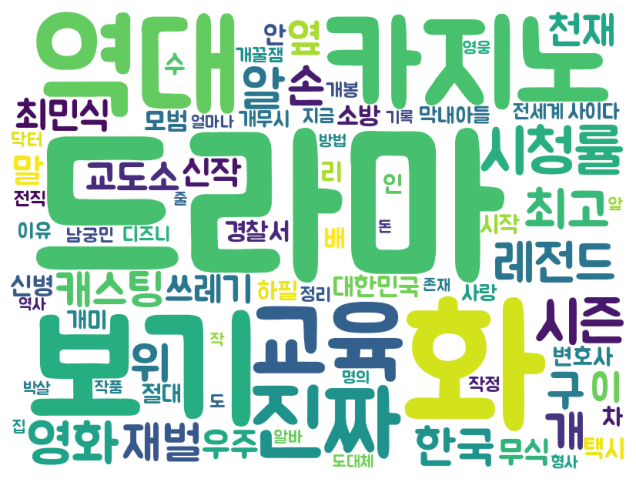

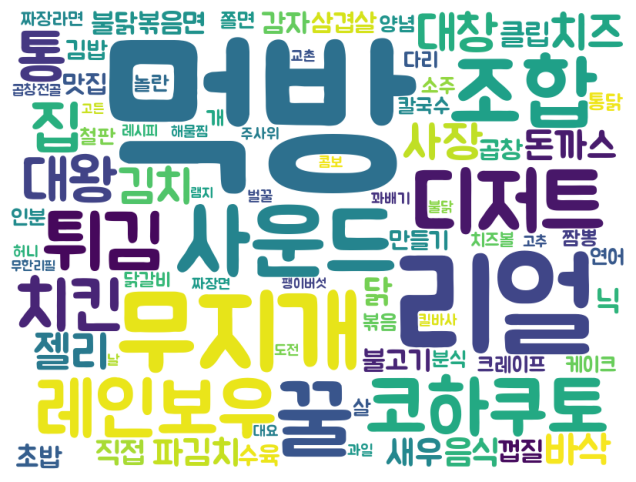

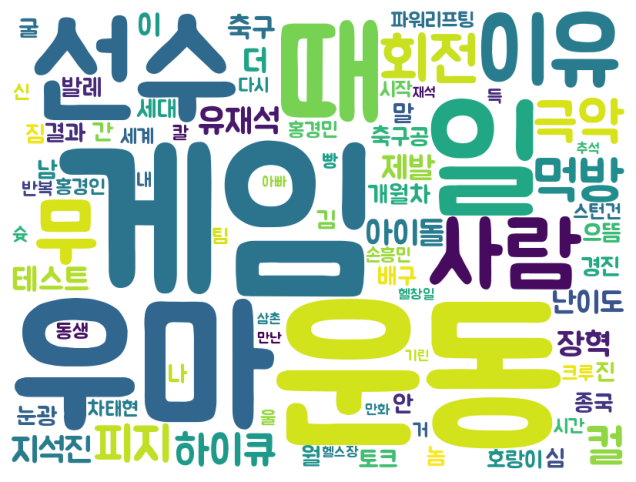

In [6]:
# 각 카테고리에서 상위 조회수 영상 100개 제목 WordCloud
# 결과물을 저장
category_names = ['ANIMAL', 'GAME', 'MOVIE', 'MUKBANG', 'SPORTS']

for category in category_names:
    query_result = get_result_byQuery(
        """
        SELECT v.video_title
        FROM TB_CHANNEL_INFO as ch
        INNER JOIN TB_VIDEO_INFO as v ON ch.channel_id = v.channel_id
        WHERE ch.category = '{}'
        ORDER BY v.view_count desc LIMIT 100;
        """.format(category)
    )
    plt.figure(figsize=(8,6))
    plt.axis('off')
    plt.imshow(get_wordCloud(query_result))
    plt.savefig('wordcloud/{}/{}_CHANNEL_VIDEO_WORDCLOUD.png'.format(category, category))

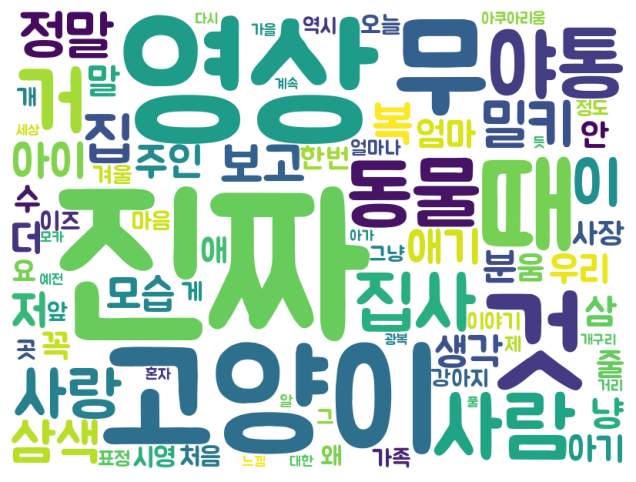

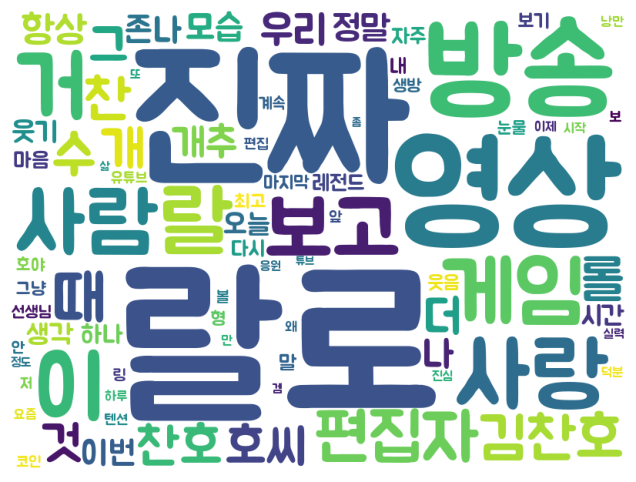

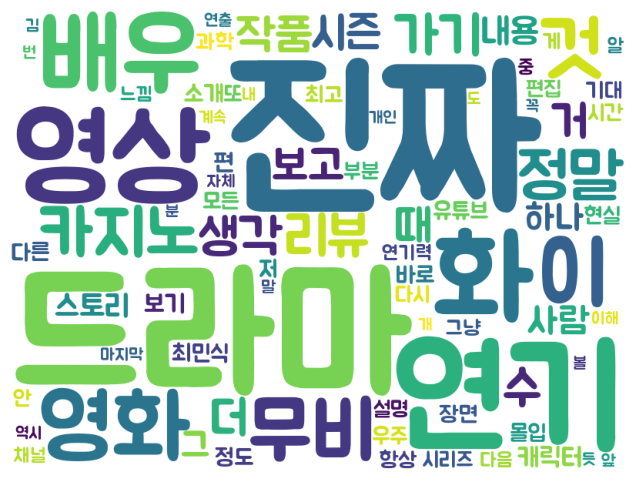

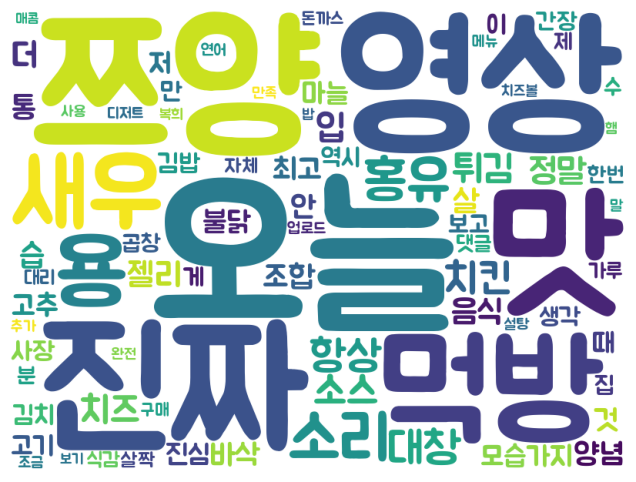

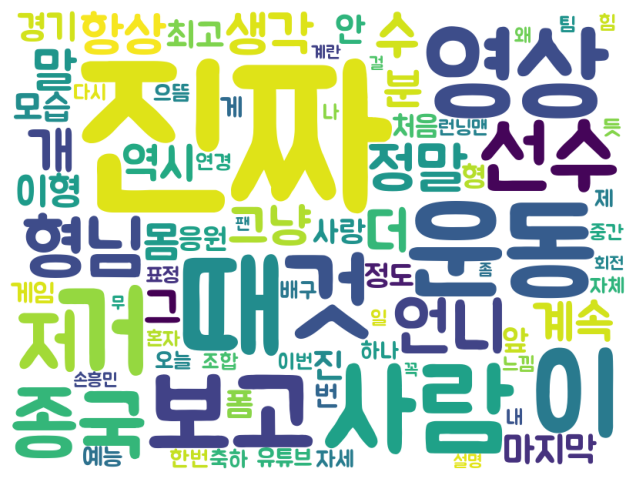

In [9]:
# 각 카테고리에서 상위 조회수 영상 100개의 덧글 WordCloud
# 결과물을 저장
for category in category_names:
    query_result = get_result_byQuery(
        """
        SELECT cmt.content
        FROM TB_COMMENT_INFO as cmt
        INNER JOIN TB_VIDEO_INFO as v ON cmt.video_id = v.video_id
        INNER JOIN (
        SELECT v.video_id
        FROM TB_CHANNEL_INFO as ch
        INNER JOIN TB_VIDEO_INFO as v ON ch.channel_id = v.channel_id
        WHERE ch.category ='{}'
        ORDER BY v.view_count desc
        LIMIT 100
        ) as top_videos ON v.video_id = top_videos.video_id;
        """.format(category)
    )

    plt.figure(figsize=(8,6))
    plt.axis('off')
    plt.imshow(get_wordCloud(query_result))
    plt.savefig('wordcloud/{}/{}_CHANNEL_COMMENT_WORDCLOUD.png'.format(category,category))

In [5]:
# 각 카테고리별 가장 인기 많았던 댓글 3개
for category in category_names:
    query_result = get_result_byQuery(
        """
        SELECT cmt.content
        FROM TB_CHANNEL_INFO as ch
        INNER JOIN TB_VIDEO_INFO as v ON ch.channel_id = v.channel_id
        INNER JOIN TB_COMMENT_INFO as cmt ON v.video_id = cmt.video_id
        WHERE ch.category = '{}'
        ORDER BY cmt.like_count desc LIMIT 3;
        """.format(category)
    )
    print("\n----------{}----------\n".format(category))
    pprint.pprint(query_result)


----------ANIMAL----------

(('동물들은 호흡이나 냄새 온도등으로 위급상황을 판단한답니다 심지어 심장 박동이나 배설물의 냄새로도 판단한다고하니 동물입장에서는 “오늘 '
  '밥은 좀 새롭게 주네” 수준이었을겁니다!',),
 ('처음엔 미안해서 달래줬지만 엄살이 심한걸 보고 “히융~” 가서 가버린게 학계의 정설입니다.',),
 ('썸넬보고 얼척없어서 달려왔어요 ㅋㅋㅋㅋㅋㅋ😂',))

----------GAME----------

(('하마의 심리를 파악해서 함정을 만들어두신 독사분도 대단하시고 혹시 독사분이 서운하실까봐 모든 함정에 걸리는 하마형도 너무 '
  '웃김ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',),
 ('지켜줘야 할 것 같은 남자 1위ㅋㅋㅋㅋㅋㅋㅋㅋㅋ',),
 ('진짜 저 거위는 언제봐도 웃음버튼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',))

----------MOVIE----------

(('이게 엄청 옛날도 아닌 100년정도 밖에 안된일이라는게 소름입니다…😭',),
 ('이런건 넷플릭스에 올라왔으면 좋겠네요.. 전세계 인이 볼수 있게..',),
 ('모든 회사는 경비가 cctv가 있습니다. 저런 경우 대리부터 짜릅니다.',))

----------MUKBANG----------

(('Getting recognized by Gordon Ramsay is awesome, meeting him in person and '
  'being invited for a taste test of a new burger is another level of '
  'awesomeness… ❤',),
 ('Tzuyang is now being recognize as a food critic and not just being a '
  'mukbanger. She gives honest opinions with the food she eats and being '
  'recognized by gordon ramsay is a whole another level. 

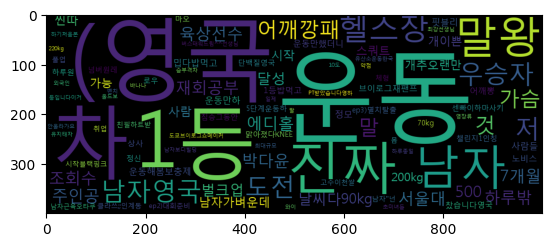

In [6]:
# 특정 유튜버 모든 영상에서 가장 많이 나온 제목 WordCloud
# 결과물을 저장

for category in category_names:
    channel_ids_inCategory = get_result_byQuery(
        """
        SELECT channel_id
        FROM TB_CHANNEL_INFO
        WHERE category ='{}'
        """.format(category)
    )

    for channel_id in channel_ids_inCategory:
        query_result = get_result_byQuery(
            """
            SELECT video_title
            FROM TB_VIDEO_INFO
            WHERE channel_id = '{}'
            """.format(channel_id[0])
        )
        plt.figure(figsize=(8,6))
        plt.axis('off')
        plt.imshow(get_wordCloud(query_result))
        plt.savefig('wordcloud/{}/{}_TITLE_WORDCLOUD.png'.format(category,channel_id[0]))

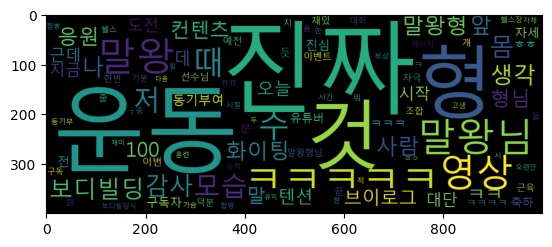

In [5]:
# 특정 유튜버 모든 영상에서 가장 많이 나온 댓글 WordCloud
# 결과물을 저장

for category in category_names:
    channel_ids_inCategory = get_result_byQuery(
        """
        SELECT channel_id
        FROM TB_CHANNEL_INFO
        WHERE category ='{}'
        """.format(category)
    )

    for channel_id in channel_ids_inCategory:
        query_result = get_result_byQuery(
            """
            SELECT cmt.content
            FROM TB_VIDEO_INFO as v
            INNER JOIN TB_COMMENT_INFO as cmt ON v.video_id = cmt.video_id
            WHERE v.channel_id = '{}'
            """.format(channel_id[0])
        )
        plt.figure(figsize=(8,6))
        plt.axis('off')
        plt.imshow(get_wordCloud(query_result))
        plt.savefig('wordcloud/{}/{}_COMMENT_WORDCLOUD.png'.format(category,channel_id[0]))

In [8]:
# 각 유튜버별 가장 인기 많았던 댓글 3개
for category in category_names:
    channel_ids_inCategory = get_result_byQuery(
        """
        SELECT channel_id
        FROM TB_CHANNEL_INFO
        WHERE category ='{}'
        """.format(category)
    )
    print("{}".format(category))
    for channel_id in channel_ids_inCategory:
        query_result = get_result_byQuery(
            """
            SELECT cmt.content
            FROM TB_VIDEO_INFO as v
            INNER JOIN TB_COMMENT_INFO as cmt ON v.video_id = cmt.video_id
            WHERE v.channel_id = '{}'
            ORDER BY cmt.like_count DESC LIMIT 3
            """.format(channel_id[0])
        )
        print("\n----------{}----------\n".format(channel_id[0]))
        pprint.pprint(query_result)

ANIMAL

----------UC22go5LdQEw-iDuxFb4C0hw----------

(('3년후도 아니고 13년후라니 넘 감동스럽....뚠냥이로 잘 성장해주었군 ㅠㅠ 보호자님께 감사드립니다.',),
 ('진짜 구조해 주시고 치료해 주셔서 감사합니다.  눈물이 멈추질 않네요. 널 그렇게 만든 짐승보다 못한 인간은 천벌을 받을꺼야. 꼭 '
  '힘내렴 아가야🫂',),
 ('얼마나 소리를 질렀으면 목이 다 쉬었네..',))

----------UC29-IlHm6kbDB1ox8GthODw----------

(('파이프 안에서 데려온 우리 누리즈들을 추억하며  😍',),
 ('인생은 까칠이처럼\n'
  '가족에게는 무니처럼\n'
  '타인에게는 꼬리처럼\n'
  '대답은 소시미처럼\n'
  '집 고를 땐 누리처럼\n'
  '엄마한텐 점남이처럼\n'
  '효도는 다리처럼\n'
  '적응은 쪼꾸미처럼\n'
  '양보는 막내처럼\n'
  '배고플땐 눈썹이처럼\n'
  '동생한테는 이쁘이처럼\n'
  '\n'
  '이렇게 항상 누리네처럼 살고 싶네용💛🤍🐈',),
 ('세상에.. 우리 막내.. 세상 무섭게 하악하다가도 집사님 손길은 받아들이고.. 너무너무 착한것같아요ㅜㅜ..',))

----------UCij19II32Olbu8_vghmYNCA----------

(('왤케 사람처럼 앉아있엌ㅋㅋㅋㅋㅋ귀여워ㅠㅠㅠ',), ('강아지 귀에서 팽이버섯이 나오네',), ('마음깊이 진심으로 감사드립니다',))

----------UCLsj_Re3SxtkbZfX_ypY1eQ----------

(('고양이 행동 분석가로써, 저 꼬마아이을 집사로 보는게 아니라 목숨걸고 보호해야될 대상으로 보는겁니다. 3번 돌려봤는데, 자는게 깨지 '
  '않게끔 조심하는점 2마리는 아래에서 번갈아가며 순찰하거나 앉아서 사방을 주시하는등. 즉 저 꼬마아이를 지켜줘야할 대상으로 인식하고 있고 '
  '꺴을때 냐아아아앙 하면서 반기는거 보면, 새끼처럼 지켜주는 대상이 아닌, 마치 여왕님처럼 생각하